# **Projet Python : Analyse des sentiments des usagers de la RATP**

**Introduction** : Il s'agit, dans ce devoir, de scrapper un certain nombre de tweets concernant la RATP, en les séparant par RER et par heure, puis de s'intéresser à la satisfaction des usagers de ces transports. On se demande s'il y a des RER qui rencontrent une meilleure satisfaction que d'autres, si pour chaque RER il y a des différences selon l'heure, comme par exemple aux heures de pointe.

Attention : la première partie du code ne doit pas être run. Elle est ici pour montrer les étapes qui nous ont permis à élaborer notre base de donnée. Il faut utiliser les base de données fournies avec le projet.

# **Partie 1** : Création de la base de données

Pour notre étude nous utilisons une base de données constituée de tweets. Ces tweets sont scrappés directement depuis Twitter à l'aide du package tweepy, mis en place à cet effet. Il s'agit donc d'abord d'installer ce package et de s'identifier auprès de Twitter afin qu'il autorise ce package à s'installer. Pour cela, nous avons créé un compte de twitter developer et nous avons utilisé nos clés d'accès. Dans la cellule de code ci-dessous, on importe également tous les modules dont nous aurons besoin pour notre projet.

In [2]:
import tweepy
import pandas as pd
import csv
import textblob
from textblob import TextBlob
import re
!pip install emoji
import emoji
import nltk
import numpy as np
import datetime
from datetime import datetime
import matplotlib.pyplot as plt

consumer_key = "f7mfvte83FP4nW97AFwvTjOKw"
consumer_secret = "1VTqtyUQIEjzvU99RXk1m6GWdOgp9sPe33nrDOdj0kX9Z7q9CJ"
access_token = "1323999317204631553-YRkTME8DyyOeJGW2feJi4v6s8OqcID"
access_token_secret = "SP1thwv8cqQmzHrsBoHwV5V5sdgKad3T7nkk3McQLrIAj"
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

Nous décidons de scrapper les tweets à l'aide d'une recherche par mots clés. Cest tweets sont stockés sous forme de liste. La fonction get_tweet se base sur l'outil "api.search" qui scrappe tous les tweets contenant un certain mot-clé. Elle prend en argument une liste de mots-clés et le nombre de tweets que l'on veut scrapper contenant un mot de cette liste de mots clés. Cependant, il faut garder en tête que le principal inconvénient du module tweepy est qu'il limite beaucoup le nombre de tweets que l'on peut scrapper, donc on peut se retrouver avec moins de tweets que l'on souhaite. De plus, on choisit de ne prendre que les tweets publiés autour de Paris (dans l'argument geocode) pour éviter d'avoir des tweets créés par des robots à l'autre bout du monde qui viennent interférer, et cela ne nous limite pas aux tweets en français. (On pouvait régler le problème des robots en se limitant au français grâce à textblob mais il y a des personnes non françaises qui peuvent tweeter sur la RATP donc choisir le géocode de Paris est la solution optimale). Il faut cependant prendre en compte que l'on aura sûrement une marge d'erreur pour le RER A. En effet, des usagers peuvent très bien tweeter en parlant d'un RER lambda "le RER a mal fonctionné ce matin" et il sera comptabilisé dans la liste des tweets sur le RER A. Nous n'avons pas trouvé comment contourner ce problème.

In [ ]:
""""
def get_tweet(key_words, n) :
    alltweets=[]
    for k in range(len(key_words)) :
        alltweets+=api.search(key_words[k], geocode='48.8534,2.3488,100km', count=n)
    return(alltweets)

liste_tweets_rer_A=get_tweet(["rer a"], 1000)
liste_tweets_rer_B=get_tweet(["rer b"], 1000)
liste_tweets_rer_C=get_tweet(["rer c"], 1000)
liste_tweets_rer_D=get_tweet(["rer D"], 1000)
liste_tweets_rer_E=get_tweet(["rer E"], 1000)
""""

On nettoie ensuite les tweets. En effet, lorsque l'on scrappe Twitter, on a beaucoup d'informations qui ne nous intéressent pas. On veut juste le tweet et son heure. La fonction "extract_tweet" ci-dessous va nous retourner l'ensemble des tweets seuls, en enlevant toutes les informations dont nous ne voulons pas. De plus, on nettoie les tweets au passage. Cela signifie que l'on enlève les @, les emojis (en ayant installé au préalable le module emoji), les liens http. De plus, il faut enlever les RT de nos tweets car sinon on aurait le même tweet le nombre de fois qu'il aurait été retweeté, ce qui peut être beaucoup. La fonction removeduplicate est une vérification finale pour supprimer les doublons.
Ensuite, on crée une fonction simple "heure_tweet" qui crée une liste remplie des heures des tweets que l'on vient de scrapper puis nettoyer. Cela nous servira plus tard à tracer la satisfaction en fonction de l'heure.

In [98]:
"""
def removeduplicate(liste):
    unique=[]
    for tweet in liste: 
        if tweet not in unique:
        unique.append(tweet)
    return unique

def extract_tweet(liste):
    tweets=[]
    twit='jeanne'
    for k in range(len(liste)) :
        twit=liste[k].text
        if twit[0]!='R' and twit[1]!='T' : #enlever les RT
            twit = re.sub("@[A-Za-z0-9]+","",twit) #enlever les @
            twit = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", twit) #enlever les http links
            twit = " ".join(twit.split())
            twit = ''.join(c for c in twit if c not in emoji.UNICODE_EMOJI) #enlever les emojis
            twit = twit.replace("#", "").replace("_", " ") #enlever les #
            twit = " ".join(w for w in nltk.wordpunct_tokenize(twit))
            twit=twit.lower() #mettre en minuscules
            tweets+=[twit]
        removeduplicate(tweets)
    return(tweets)

def heure_tweet(liste) :
    heures=[]
    liste2=removeduplicate(liste)
    for k in range(len(liste2)) :
        tweet=liste2[k].text
        if tweet[0]!='R' and tweet[1]!='T' :
            heures.append(liste2[k].created_at)
    return(heures)

liste_tweets_rer_A_propre=extract_tweet(liste_tweets_rer_A)
liste_tweets_rer_B_propre=extract_tweet(liste_tweets_rer_B)
liste_tweets_rer_C_propre=extract_tweet(liste_tweets_rer_C)
liste_tweets_rer_D_propre=extract_tweet(liste_tweets_rer_D)
liste_tweets_rer_E_propre=extract_tweet(liste_tweets_rer_E)

time_tweets_rer_A=heure_tweet(liste_tweets_rer_A)
time_tweets_rer_B=heure_tweet(liste_tweets_rer_B)
time_tweets_rer_C=heure_tweet(liste_tweets_rer_C)
time_tweets_rer_D=heure_tweet(liste_tweets_rer_D)
time_tweets_rer_E=heure_tweet(liste_tweets_rer_E)
"""

'\ndef removeduplicate(liste):\n    unique=[]\n    for tweet in liste: \n        if tweet not in unique:\n        unique.append(tweet)\n    return unique\n\ndef extract_tweet(liste):\n    tweets=[]\n    twit=\'jeanne\'\n    for k in range(len(liste)) :\n        twit=liste[k].text\n        if twit[0]!=\'R\' and twit[1]!=\'T\' : #enlever les RT\n            twit = re.sub("@[A-Za-z0-9]+","",twit) #enlever les @\n            twit = re.sub(r"(?:\\@|http?\\://|https?\\://|www)\\S+", "", twit) #enlever les http links\n            twit = " ".join(twit.split())\n            twit = \'\'.join(c for c in twit if c not in emoji.UNICODE_EMOJI) #enlever les emojis\n            twit = twit.replace("#", "").replace("_", " ") #enlever les #\n            twit = " ".join(w for w in nltk.wordpunct_tokenize(twit))\n            twit=twit.lower() #mettre en minuscules\n            tweets+=[twit]\n        removeduplicate(tweets)\n    return(tweets)\n\ndef heure_tweet(liste) :\n    heures=[]\n    liste2=removed

Dans la section ci-dessous, nous présentons le code qui nous a permis d'établir notre base de donnée. Ce code a tourné dans un autre notebook, on le présente ici, mais utilisons la base produite par l'autre notebook. En effet, tweepy possède un inconvénient majeur, qui est qu'il limite le nombre de tweets qu'on peut scrapper. La limite est établie à 100. Nous avons donc scrappé 100 tweets plusieurs fois, avons réuni les tweet scrapés un une seule base de donnée en fonction du RER, et avons mis le tout sous forme de DataFrame puis de fichier CSV. Nos base de données comportent chacune presque 1 000 tweet, ce qui semble raisonnable pour avoir des résultats pertinents. On aurait pu continuer le processus jusqu'à avoir 10000, 100000, ou autant de tweet que souhaité.

In [ ]:
""""
from google.colab import drive #module qui permet d'enregistrer sur le drive
drive.mount("drive", force_remount=True)

df_rerApropre=pd.DataFrame(liste_tweets_rer_A_propre) #transformation en dataframe
df_heureA=pd.DataFrame(time_tweets_rer_A)
df_rerA=pd.concat([df_rerApropre, df_heureA], axis=1)#concaténation des dataframe
df_rerA.columns=('tweet_RER_A','heure_du_tweet') 
df_rerA.to_csv('rerA0.csv')
!cp rerA0.csv "drive/My Drive/RER/"

df_rerBpropre=pd.DataFrame(liste_tweets_rer_B_propre) #transformation en dataframe
df_heureB=pd.DataFrame(time_tweets_rer_B)
df_rerB=pd.concat([df_rerBpropre, df_heureB], axis=1)#concaténation des dataframe 
df_rerB.columns=('tweet_RER_B','heure_du_tweet') 
df_rerB.to_csv('rerB0.csv')
!cp rerB0.csv "drive/My Drive/RER/"

df_rerCpropre=pd.DataFrame(liste_tweets_rer_C_propre) #transformation en dataframe
df_heureC=pd.DataFrame(time_tweets_rer_C)
df_rerC=pd.concat([df_rerCpropre, df_heureC], axis=1)#concaténation des dataframe 
df_rerC.columns=('tweet_RER_C','heure_du_tweet') 
df_rerC.to_csv('rerC0.csv')
!cp rerC0.csv "drive/My Drive/RER/"

df_rerDpropre=pd.DataFrame(liste_tweets_rer_D_propre) #transformation en dataframe
df_heureD=pd.DataFrame(time_tweets_rer_D)
df_rerD=pd.concat([df_rerDpropre, df_heureD], axis=1)#concaténation des dataframe 
df_rerD.columns=('tweet_RER_D','heure_du_tweet') 
df_rerD.to_csv('rerD0.csv')
!cp rerD0.csv "drive/My Drive/RER/"

df_rerEpropre=pd.DataFrame(liste_tweets_rer_E_propre) #transformation en dataframe
df_heureE=pd.DataFrame(time_tweets_rer_E)
df_rerE=pd.concat([df_rerEpropre, df_heureE], axis=1)#concaténation des dataframe 
df_rerE.columns=('tweet_RER_E','heure_du_tweet') 
df_rerE.to_csv('rerE0.csv')
!cp rerE0.csv "drive/My Drive/RER/"
""""

In [ ]:
"""
!ls "drive/My Drive/RER/"
""""

In [ ]:
"""
dataA=[]
for k in range(8):
  dataA.append(pd.read_csv("drive/My Drive/RER/rerA"+str(k)+".csv"))

dataB=[]
for k in range(8):
  dataB.append(pd.read_csv("drive/My Drive/RER/rerB"+str(k)+".csv"))

dataC=[]
for k in range(8):
  dataC.append(pd.read_csv("drive/My Drive/RER/rerC"+str(k)+".csv"))

dataD=[]
for k in range(8):
  dataD.append(pd.read_csv("drive/My Drive/RER/rerD"+str(k)+".csv"))

dataE=[]
for k in range(8):
  dataE.append(pd.read_csv("drive/My Drive/RER/rerE"+str(k)+".csv"))
""""

In [ ]:
"""
frameA = pd.concat(dataA, axis=0, ignore_index=True)
frameA=frameA.drop(frameA.columns[0], axis='columns')

frameB = pd.concat(dataB, axis=0, ignore_index=True)
frameB=frameB.drop(frameB.columns[0], axis='columns')

frameC = pd.concat(dataC, axis=0, ignore_index=True)
frameC=frameC.drop(frameC.columns[0], axis='columns')

frameD = pd.concat(dataD, axis=0, ignore_index=True)
frameD=frameD.drop(frameD.columns[0], axis='columns')

frameE = pd.concat(dataE, axis=0, ignore_index=True)
frameE=frameE.drop(frameE.columns[[0,3]], axis='columns')
"""

In [ ]:
"""
frameA.to_csv('rerA.csv')
!cp rerA.csv "drive/My Drive/RER/"

frameB.to_csv('rerB.csv')
!cp rerB.csv "drive/My Drive/RER/"

frameC.to_csv('rerC.csv')
!cp rerC.csv "drive/My Drive/RER/"

frameD.to_csv('rerD.csv')
!cp rerD.csv "drive/My Drive/RER/"

frameE.to_csv('rerE.csv')
!cp rerE.csv "drive/My Drive/RER/"
"""

On pourra ensuite ouvrir les fichiers pour pouvoir analyser nos listes de tweets correspondant à chaque ligne, qui sont désormais bien plus longues que ce que api.search nous donnait à chaque fois.

*Monsieur le professeur, veuillez mettre ci-dessous, le chemin d'accès de nos bases de données situées sur notre github correspondant à celui de votre ordinateur.*


In [19]:
tweets_A=[]
heures_A=[]
crA=csv.reader(open(r'C:\Users\jeann\Desktop\RER\rerA.csv'), delimiter=';')
for row in crA : 
    if row[2]!='heure_du_tweet' :
        tweets_A.append(row[1])
        heures_A.append(datetime.strptime(row[2], "%Y-%m-%d %H:%M:%S"))

tweets_B=[]
heures_B=[]
crB=csv.reader(open(r'C:\Users\jeann\Desktop\RER\rerB.csv'), delimiter=';')
for row in crB : 
    if row[2]!='heure_du_tweet' :
        tweets_B.append(row[1])
        heures_B.append(datetime.strptime(row[2], "%Y-%m-%d %H:%M:%S"))

tweets_C=[]
heures_C=[]
crC=csv.reader(open(r'C:\Users\jeann\Desktop\RER\rerC.csv'), delimiter=';')
for row in crC : 
      if row[2]!='heure_du_tweet' : 
        tweets_C.append(row[1])
        heures_C.append(datetime.strptime(row[2], "%Y-%m-%d %H:%M:%S"))

tweets_D=[]
heures_D=[]
crD=csv.reader(open(r'C:\Users\jeann\Desktop\RER\rerD.csv'), delimiter=';')
for row in crD : 
      if row[2]!='heure_du_tweet' : 
        tweets_D.append(row[1])
        heures_D.append(datetime.strptime(row[2], "%Y-%m-%d %H:%M:%S"))

tweets_E=[]
heures_E=[]
crE=csv.reader(open(r'C:\Users\jeann\Desktop\RER\rerE.csv'), delimiter=';')
for row in crE :
    if row[2]!='heure_du_tweet' : 
        tweets_E.append(row[1])
        heures_E.append(datetime.strptime(row[2], "%Y-%m-%d %H:%M:%S"))

# **Partie 2 :** Analyse de sentiment


Dans un premier temps, on peut essayer de se rendre compte de ce que pensent les usagers du RER en fonction de l'heure de la journée, ou même du RER. Par exemple, dans un premier temps, on peut regarder la longueur de chacune des listes, puis la longueur selon l'heure.

In [24]:
print(len(tweets_A), len(tweets_B), len(tweets_C), len(tweets_D), len(tweets_E))

620 457 451 465 320


Déjà, on se rend compte que le RER A fait plus parler que les autres, alors que le RER E moins. Les RER B, C et D comptent à peu près autant de tweets. Il paraît assez raisonnable de supposer que la plupart du temps, les passagers tweetent lorsqu'il y a un problème, ainsi on va s'attendre à avoir plus de sentiments négatifs pour le RER A que les autres, et moins pour le RER E.

In [31]:
def tweet_certaine_heure(liste_tweets, heure_tweet, heure) :
    tweets_à_cette_heure=[]
    for k in range(len(heure_tweet)) :
        if heure_tweet[k].hour==heure :
            tweets_à_cette_heure.append(liste_tweets[k])
    return(tweets_à_cette_heure)

print(len(tweet_certaine_heure(tweets_D, heures_D, 7)), len(tweet_certaine_heure(tweets_D, heures_D, 14)))

44 20


On a créé ci-dessus une fonction qui donne simplement la liste des tweets écrits à une heure précise, en prenant en argument la liste des tweets d'une ligne et son moment d'écriture associé. On l'a ensuité appliquée en exemple à une ligne (ici la ligne D) à deux heures différentes : 7h, pleine heure de pointe et 14h, heure creuse. On constate qu'il y a deux fois plus de tweets écrits à cette heure de pointe plutôt qu'à l'heure creuse. On s'attend donc à trouver plus de "négativité" et de mécontentement des passagers aux heures de pointe qu'aux heures creuses.

On va maintenant chercher à illustrer quantitativement les sentiments des usagers d'une ligne précise de RER à une heure précise. Pour cela on commence par créer la fonction concatenation ci-dessous. Elle va permettre de transformer une liste de tweets en une seule phrase géante. Cela rend la fonction de sentiment de textblob plus précise. En effet, ensuite, on crée la fonction "sentiment1". Elle analyse les sentiments d'une ligne à une certaine heure de manière plus précise que si l'on calculait le sentiment de chaque tweet et que l'on faisait ensuite une moyenne des sentiments car les tweets contiennent peu de mots. Ainsi, plutôt que d'appliquer la fonction sentiment.polarity de textblob à chaque tweet, on va l'appliquer à la phrase géante contenant l'ensemble des tweets d'une ligne pour avoir directement le sentiment moyen des tweets sur cette ligne à l'heure donnée.

In [43]:
def concatenation(liste) :
    liste_geante=[]
    string=''
    for tweet in liste :
        string+=tweet
    liste_geante.append(string)
    return(liste_geante)

In [44]:
def sentiment1(liste_tweets, liste_heures, heure) :
    liste_tweets_heure=[]
    for k in range(len(liste_heures)) :
        if liste_heures[k].hour==heure : #pour ne garder que les tweets produits à cette heure-là
            liste_tweets_heure+=liste_tweets[k]
    liste_tweets_heure=concatenation(liste_tweets_heure)
    blob=TextBlob(liste_tweets_heure[0])
    return(blob.sentiment.polarity)

In [45]:
sentiment1(tweets_C, heures_C, 7)

-0.9666666666666667

On a donc pris en exemple, ci-dessus, la satisfaction moyenne des usagers du RER C à 7h, heure de pointe. sentiment.polarity est une fonction qui va de -1 à 1, ainsi on peut en déduire qu'à 7h, les usagers du RER A étaient globalement vraiment non satisfaits du service. 

On va maintenant chercher à tracer la satisfaction en fonction de l'heure. On s'attend essentiellement à observer un mécontentement des usagers aux heures de pointe.

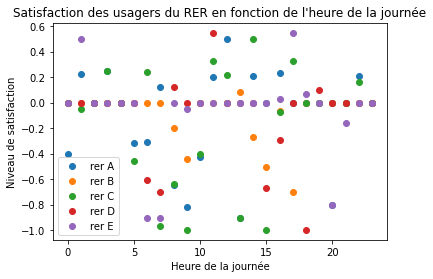

In [46]:
heures=[k for k in range(24)]
satisfaction_rer_A=[sentiment1(tweets_A, heures_A, k) for k in range(24)]
satisfaction_rer_B=[sentiment1(tweets_B, heures_B, k) for k in range(24)]
satisfaction_rer_C=[sentiment1(tweets_C, heures_C, k) for k in range(24)]
satisfaction_rer_D=[sentiment1(tweets_D, heures_D, k) for k in range(24)]
satisfaction_rer_E=[sentiment1(tweets_E, heures_E, k) for k in range(24)]
plt.plot(heures,satisfaction_rer_A, 'o', label='rer A')
plt.plot(heures,satisfaction_rer_B, 'o', label= 'rer B')
plt.plot(heures,satisfaction_rer_C, 'o', label= 'rer C')
plt.plot(heures,satisfaction_rer_D, 'o', label= 'rer D')
plt.plot(heures,satisfaction_rer_E, 'o', label= 'rer E')
plt.xlabel('Heure de la journée')
plt.ylabel('Niveau de satisfaction')
plt.title("Satisfaction des usagers du RER en fonction de l'heure de la journée")
plt.legend()
plt.show()

On a donc ci-dessus un graphique illustrant la satisfaction des usagers du RER en fonction de l'heure de la journée. Plus on est proches de -1, moins les usagers sont satisfaits. A l'inverse, plus on se rapproche de 1, plus ils le sont. La satisfaction varie beaucoup selon l'heure, ont peut constater par exemple que le matin les usagers du RER A sont très insatisfaits du service qui leur est proposé, et les usagers du RER B sont en moyenne plutôt mécontents toute la journée car ils dépassent rarement la barre du 0. En moyenne on peut remarquer que l'on est plus souvent du côté négatif que positif et que les tweets positifs ne sont pas autant poussés que les tweets négatifs (en effet, on va souvent vers -1 alors qu'on dépasse rarement 0,5).  Cependant, on peut constater que l'on manque un peu de données. En effet, lorsque le niveau de satisfaction est à 0 pile, on peut penser qu'il y avait très peu voire pas de tweets sur le RER en question à cette heure là. C'est notamment le cas du RER E, les usagers ont l'air de faire peu de tweets à son sujet. Le schéma qui a l'air de revenir est une insatisfaction aux heures de pointe (plus forte le matin) et les passagers sont neutres voire plutôt satisfaits le reste du temps.

On essaye ensuite de créer notre propre fonction d'analyse de sentiments des tweets. En effet nous ne savons pas à quel points les tweets peuvent utiliser du vocabulaire que sentiment.polarity ne saura pas prendre en compte. Ainsi, on va chercher à créer une fonction qui va repérer les tweets négatifs, ou plutôt les mots négatifs qu'ils contiennent. Pour cela, elle utilisera simplement un compteur de mots négatifs qui viennent d'une liste que l'on a créée et qui couvre un grand nombre de mots négatifs qui peuvent être dits à propos des transports. Ainsi avec notre nouvelle fonction sentiment2, plus on obtient un score élevé, plus il y a eu de tweets négatifs sur une certaine ligne. On va également tracer la satisfaction en fonction de l'heure avec sentiment2 et comparer le résultat à celui obtenu précédemment.

In [47]:
mots_negatifs=["aucun", "retard", "grève", "grèves", "idiot", "idiots", "blindé", "bondé", "panne", "haine", "seum", "souci", "soucis", "problème", "problèmes", "malaise", "monde", "danger", "chaud", "voleur", "agression", "frotteur", "sexuel", "controler", "debout", "putain", "nsm", "ptn","bagage", "incident", "contrôleurs","perturbé", "sale", "dégradé", "puant", "pue", "crade", "attente", "pute", "long", "longtemps", "plombes", "chiant", "merde", "relou", "perturbations", "interrompu", "greve", "greves", "colis", "suspect", "police"]

def sentiment_construit(tweet) :
    phrase=tweet.split()
    compteur=0
    for k in range(len(phrase)) :
        if phrase[k] in mots_negatifs :
            compteur+=1
    return(compteur)

def score(liste) :
    S=0
    for tweet in liste :
        S+=sentiment_construit(tweet)
    return(S)

def sentiment2(liste_tweets, liste_heures, heure) :
    liste_tweets_heure=[]
    for k in range(len(liste_heures)) :
        if liste_heures[k].hour==heure : 
            liste_tweets_heure.append(liste_tweets[k])
    return(score(liste_tweets_heure))


Nous allons montrer un exemple d'utilisation de notre fonction sentiment_construit en utilisant des phrases négatives possibles  à propos du RER. On prend en exemple ici un tweet neutre et un tweet négatif sur le RER B.

In [48]:
print(tweets_B[227], sentiment_construit(tweets_B[227]))
print(tweets_B[161], sentiment_construit(tweets_B[161]))

ce bon vieux rer b 0
incident en gare du nord : trafic interrompu sur le rer b et le rer d , fortes perturbations rt ffranouche 3


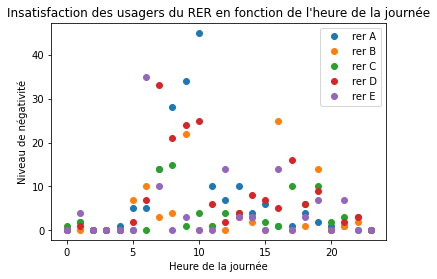

In [49]:
heures=[k for k in range(24)]
satisfaction_rer_A_2=[sentiment2(tweets_A, heures_A, k) for k in range(24)]
satisfaction_rer_B_2=[sentiment2(tweets_B, heures_B, k) for k in range(24)]
satisfaction_rer_C_2=[sentiment2(tweets_C, heures_C, k) for k in range(24)]
satisfaction_rer_D_2=[sentiment2(tweets_D, heures_D, k) for k in range(24)]
satisfaction_rer_E_2=[sentiment2(tweets_E, heures_E, k) for k in range(24)]
plt.plot(heures,satisfaction_rer_A_2, 'o', label='rer A')
plt.plot(heures,satisfaction_rer_B_2, 'o', label= 'rer B')
plt.plot(heures,satisfaction_rer_C_2, 'o', label= 'rer C')
plt.plot(heures,satisfaction_rer_D_2, 'o', label= 'rer D')
plt.plot(heures,satisfaction_rer_E_2, 'o', label= 'rer E')
plt.xlabel('Heure de la journée')
plt.ylabel('Niveau de négativité')
plt.title("Insatisfaction des usagers du RER en fonction de l'heure de la journée")
plt.legend()
plt.show()

On constate quand même qu'il y a un niveau d'insatisfaction général puisqu'il y a peu de tweets qui restent à 0 alors que dans notre fonction, contrairement à celle de textblob, 0 représente le neutre et le positif. Ainsi, à part pour le RER E qui manque un peu de tweets à son sujet, on voit bien que l'on atteint des scores plutôt élevés sur chaque ligne, notamment à l'heure de pointe du matin, ce qui témoigne d'un mécontentement global des services publics de transport. On a l'impression que cette méthode recense plus la négativité que la fonction de texblob, certainement parce qu'on a intégré du vocabulaire plus utilisé sur Internet que celui de sentiment1. Cependant, elle reste légèrement imprécise car on ne peut pas couvrir les tweets positifs. Nous avons choisi de ne pas avoir de compteur de mots positifs pour éviter de prendre en compte des tweets ironiques dans les tweets positifs. En effet, on pourrait très bien avoir un usager qui tweete "Génial le RER ce matin" de manière ironique et il serait perçu comme un tweet positif. C'est un problème que rencontre sûrement la fonction sentiment1 aussi. Globalement, on retrouve le résultat obtenu avec la fonction 1 : une grande insatisfaction à l'heure de pointe le matin, également celle de fin d'après-midi mais en plus modéré. De plus, les plus gros "râleurs" semblent être les usagers du RER A et du RER D qui atteignent des scores négatifs très hauts en heure de pointe.

Ensuite, on va chercher à identifier quels sont les problèmes qui sont rencontrés en créant un histogramme qui va classer les tweets par problème rencontré. On va définir des catégories majeures : les retards, le RER bondé, la présence de contrôleurs, la gêne causée par d'autres passagers (beaucoup de femmes sont victimes d'attouchements non consentis dans les transports), et les incidents (comme un colis suspect par exemple).

Text(0.5, 1.0, 'Proportion des différents problèmes rencontrés dans le RER')

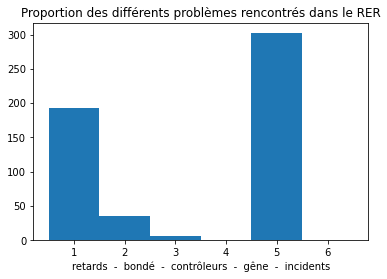

In [50]:
tweets=tweets_A+tweets_B+tweets_C+tweets_D+tweets_E

problemes_retard=['retard', 'bourre', 'lent', 'ralenti', 'long', 'longue', 'retardé', 'retards', 'interrompu', 'attente', 'attendre', 'attendu', 'plombes', 'rater', 'rate', 'longtemps']
problemes_RER_bondé=['monde', 'debout', 'chaud', 'surpeuplé', 'blindé', 'surpeuple', 'blinde', 'masse', 'entassé']
problemes_controleur=['contrôleur', 'controleur', "contrôler", "controler", "contrôleurs", "controleurs", 'police', 'amende', 'prune', 'payer' 'contrôle', 'controle']
problemes_gene=['relou', 'frotteur', 'sexuel', 'sexuelle', 'agression', 'agresser', 'touché', 'toucher', 'penible', 'dangereux', 'touchée', 'inquiète', 'inquiétant']
problemes_incidents=['malaise', 'colis', 'bagage', 'suspect', 'oublié', 'incident', 'incidents', 'danger', 'accident', 'grève', 'grèves', 'greve', 'greves']

histo=[]

for tweet in tweets :
    phrase=tweet.split()
    for mot in phrase :
        if mot in problemes_retard :
            histo.append(1)
        if mot in problemes_RER_bondé :
            histo.append(2)
        if mot in problemes_controleur :
            histo.append(3)
        if mot in problemes_gene :
            histo.append(4)
        if mot in problemes_incidents :
            histo.append(5)
            
plt.hist(histo,bins=[0.5,1.5,2.5,3.5,4.5,5.5,6.5])
plt.xlabel('retards  -  bondé  -  contrôleurs  -  gêne  -  incidents')
plt.title('Proportion des différents problèmes rencontrés dans le RER')

L'histogramme ci-dessus montre la proportion des différentes catégories de problèmes que l'on peut imaginer (tous RER confondus). On a imaginé une première catégorie : les retards, qui représentent une grande partie des problèmes possibles. Le RER trop plein semble aussi être source de tweets négatifs, dans une moindre mesure. Les contrôleurs semblent ne pas trop poser de problème et heureusement, on n'a aucun tweet qui recense un attouchement non consenti, que l'on sait fréquents dans les RER. Enfin, le problème majeur est, sans surprises, celui des incidents (tels que malaise voyageur, colis suspect...) On va maintenant essayer de vérifier si ceci s'observe, à échelle plus petite, pour chaque RER.

Text(0.5, 1.0, 'Proportion des différents problèmes rencontrés dans le RER')

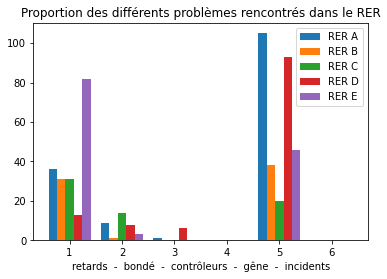

In [51]:
histoA=[]
histoB=[]
histoC=[]
histoD=[]
histoE=[]

for tweet in tweets_A :
    phrase=tweet.split()
    for mot in phrase :
        if mot in problemes_retard :
            histoA.append(1)
        if mot in problemes_RER_bondé :
            histoA.append(2)
        if mot in problemes_controleur :
            histoA.append(3)
        if mot in problemes_gene :
            histoA.append(4)
        if mot in problemes_incidents :
            histoA.append(5)
            
for tweet in tweets_B :
    phrase=tweet.split()
    for mot in phrase :
        if mot in problemes_retard :
            histoB.append(1)
        if mot in problemes_RER_bondé :
            histoB.append(2)
        if mot in problemes_controleur :
            histoB.append(3)
        if mot in problemes_gene :
            histoB.append(4)
        if mot in problemes_incidents :
            histoB.append(5)
            
for tweet in tweets_C :
    phrase=tweet.split()
    for mot in phrase :
        if mot in problemes_retard :
            histoC.append(1)
        if mot in problemes_RER_bondé :
            histoC.append(2)
        if mot in problemes_controleur :
            histoC.append(3)
        if mot in problemes_gene :
            histoC.append(4)
        if mot in problemes_incidents :
            histoC.append(5)
            
for tweet in tweets_D :
    phrase=tweet.split()
    for mot in phrase :
        if mot in problemes_retard :
            histoD.append(1)
        if mot in problemes_RER_bondé :
            histoD.append(2)
        if mot in problemes_controleur :
            histoD.append(3)
        if mot in problemes_gene :
            histoD.append(4)
        if mot in problemes_incidents :
            histoD.append(5)
            
for tweet in tweets_E :
    phrase=tweet.split()
    for mot in phrase :
        if mot in problemes_retard :
            histoE.append(1)
        if mot in problemes_RER_bondé :
            histoE.append(2)
        if mot in problemes_controleur :
            histoE.append(3)
        if mot in problemes_gene :
            histoE.append(4)
        if mot in problemes_incidents :
            histoE.append(5)            
            
plt.hist([histoA, histoB, histoC, histoD, histoE], bins=[0.5,1.5,2.5,3.5,4.5,5.5,6.5], label=['RER A', 'RER B', 'RER C', 'RER D', 'RER E'])
plt.legend()
plt.xlabel('retards  -  bondé  -  contrôleurs  -  gêne  -  incidents')
plt.title('Proportion des différents problèmes rencontrés dans le RER')

On constate le résultat général obtenu sur tous les RER plus haut : beaucoup de retards et surtout beaucoup d'incidents (qui sont liés de toute façon). Ceci est particulièrement vérifié pour le RER A, ainsi que le RER D qui a une proportion d'incidents assez impressionnante par rapport aux autres. Le RER E semble avoir beaucoup de retard (surtout lorsqu'on se rappelle que la liste de tweets sur le RER E est moins fournie que les autres), mais pas forcément causés par des incidents puisqu'il y a plus de tweets de retards que d'incidents. Contrairement à ce que l'on pourrait penser, le RER B est celui qui rencontre le moins de problèmes. Enfin, le RER C n'en rencontre pas beaucoup non plus, même s'il semble être le plus rempli. Les seuls RER qui présentent des contrôleurs (du moins dans les tweets récents à ce sujet) sont le A et le D. 

# **Partie 4 :** Réponse automatique à un tweet négatif

Nous souhaitons créer un bot de réponse automatique aux tweets négatifs sur la RATP

In [3]:
def createauth():
    """
    se connecte à l'api twitter
    """
    consumer_key = "f7mfvte83FP4nW97AFwvTjOKw"
    consumer_secret = "1VTqtyUQIEjzvU99RXk1m6GWdOgp9sPe33nrDOdj0kX9Z7q9CJ"
    access_token = "1323999317204631553-YRkTME8DyyOeJGW2feJi4v6s8OqcID"
    access_token_secret = "SP1thwv8cqQmzHrsBoHwV5V5sdgKad3T7nkk3McQLrIAj"
	
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)

    api = tweepy.API(auth)
    return api,auth

In [4]:
from tweepy.auth import OAuthHandler

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api, auth = createauth()
#api.update_status(status="Bonjour depuis Python") #pour écrire dans twitter, ici en hashtag pour ne pas se faire bannir

Ici nous avons implémenter de quoi avoir des tweet en direct. L'algorithme fonctionne dans le sens où on a bien des tweet en direct. En revanche le filtre de sélection par mot clés ne fonctionne pas très bien.

In [ ]:
from tweepy.streaming import StreamListener
import time
import json

class listener(StreamListener):

    def on_data(self, data):
        all_data = json.loads(data)

        id_tweet = all_data["id_str"]
        tweet = all_data["text"]
        username = all_data["user"]["screen_name"]
        
        print(username, tweet) # pour afficher les tweets
      
        return True

    def on_error(self, status):
        print(status)

api, auth = createauth()

twitterStream = tweepy.Stream(auth, listener())
stream=twitterStream.filter(track=["RATP", "RER"]) 


Nous avons donc décidé de réutiliser la fonction search comme précédemment et avons demandé à ce qu'elle retourne les tweet les plus récents. Ensuite nous demandons à notre bot d'effectuer une réponse. La commande qui envoie des messages sur twiiter est en # afin de en pas se faire bannir de la palteforme, ce dernier pourra être enlever à des fins de démonstration ou de vérification. 
On remarque que le bot fonctionne bien, il utilise la deuxième fonction de sentiment que nosu avons construites. Si le sentiment est négatif, on extrait le nom de l'utilisateur afin de le mentionner dans le tweet de réponse.

In [71]:
test=api.search(["RATP"], geocode='48.8534,2.3488,100km', count=100,  result_type=["recent"])

k=0
while test[k].entities["user_mentions"]==[]:
    k=k+1
    

nom= test[k].entities["user_mentions"][0]["screen_name"]

print(nom)

twet=test[k].text
print(twet)
score=sentiment_construit(twet)
print(score)
if score != 0 : 
  message="@"+nom +" nous sommes désolés pour le désagrément"
  print(message)  
  #api.update_status(status = message)

Portes_Thomas
RT @Portes_Thomas: Métro ligne 9. Contrôle de la police RATP. Le wagon est composé d’une quinzaine de personnes. Contrôle aléatoire qui tom…
1
@Portes_Thomas nous sommes désolés pour le désagrément


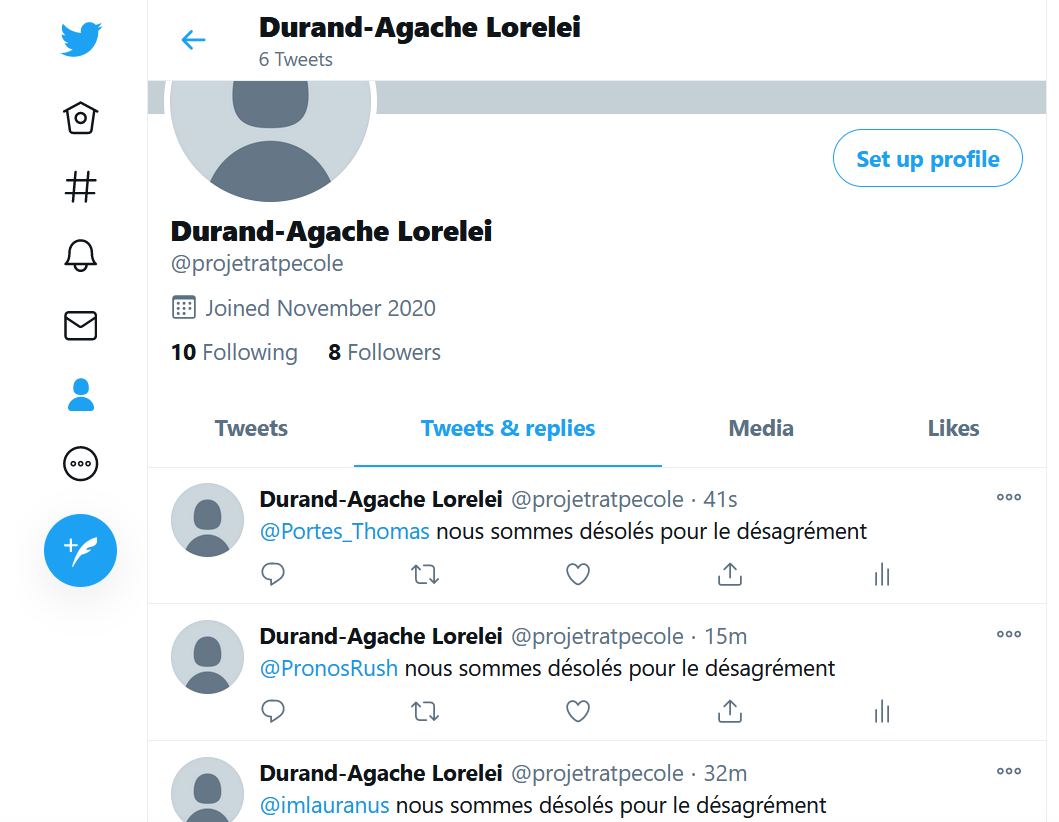